In [1]:
# set up Python environment: numpy for numerical routines, and matplotlib for plotting
import numpy as np
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

# The caffe module needs to be on the Python path;
#  we'll add it here explicitly.
import sys
import caffe
import cv2
# If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

### Load the weights, graph and mean file:

In [2]:
PATCH_SIZE = 100

WEIGHTS_FILE = '/home/jing/Documents/CNN_tabletennis/end2end_regress_iter_20000.caffemodel'
DEPLOY_FILE = '/home/jing/Documents/CNN_tabletennis/models/end2end_regression_deploy.prototxt'
MEAN_FILE = '/home/jing/Documents/CNN_tabletennis/data/mean.npy'

mu = np.load(MEAN_FILE)
mu = mu.mean(1).mean(1)
print mu

net = caffe.Net(DEPLOY_FILE, WEIGHTS_FILE, caffe.TEST)

transformer = caffe.io.Transformer({'data':net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))#nChannels w h?
transformer.set_mean('data', mu)
transformer.set_raw_scale('data', 255)
transformer.set_channel_swap('data', (2,1,0))#RGB to BGR

[ 116.1987664    86.25564234   87.22195852]


### Load image and ground truth probability map:

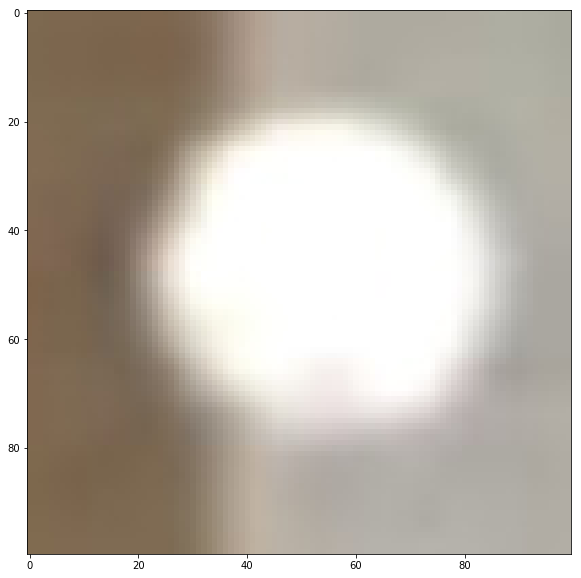

In [3]:
#img_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.jpg'
#prob_name = '/home/jing/Documents/TableTennis/TableTennis/build/tabletennis_test/0015R024502.prob.jpg'
img_name = '/media/jing/0C4F0EAC0C4F0EAC/project/tabletennis/tabletennis/0001L040802.jpg'
prob_name = '/media/jing/0C4F0EAC0C4F0EAC/project/tabletennis/tabletennis/0001L040802.prob.jpg'

image = caffe.io.load_image(img_name)
image = cv2.resize(image, (PATCH_SIZE, PATCH_SIZE))
plt.imshow(image)

### show the predicted probability map:

0.000365763 0.999901


(-0.5, 49.5, 49.5, -0.5)

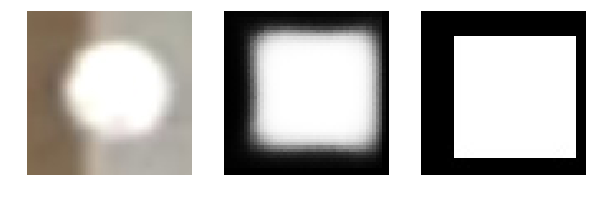

In [4]:
transformed_image = transformer.preprocess('data', image)
net.blobs['data'].data[0,...] = transformed_image

output = net.forward()

sodlt = net.blobs['sodlt_norm'].data[0][0]
print np.min(sodlt), np.max(sodlt)

plt.subplot(1, 3, 1)
plt.imshow(image); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sodlt); plt.axis('off')
plt.subplot(1, 3, 3)

prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

### show the bounding box computed from the probability map:

we can see that the bounding box is not accurate enough, thus a regression step is necessary.

(-0.5, 49.5, 49.5, -0.5)

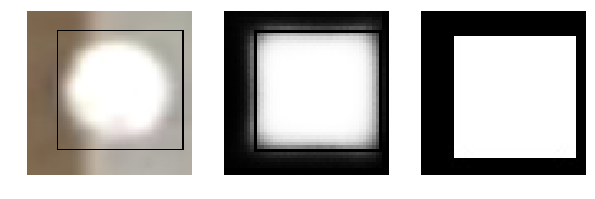

In [6]:
(x1,y1,x2,y2) = bbox = net.blobs['roi'].data[0]

output_img = image.copy()
cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)

plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(sodlt); plt.axis('off')

### Regression

after the regression step, the new bounding box contains the whole body of the object(ball), and less context.

[ 14.23451138  10.36327744  42.49469376  37.13496399]


(-0.5, 49.5, 49.5, -0.5)

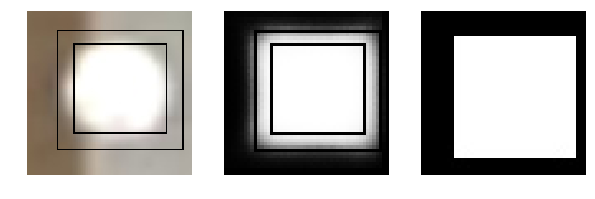

In [8]:
(x1,y1,x2,y2) = regress = output['bbox_pred'][0]
print regress

cv2.rectangle(output_img, (int(x1*2),int(y1*2)), (int(x2*2), int(y2*2)), (0,0,255), 1)

plt.subplot(1, 3, 1)
plt.imshow(output_img); plt.axis('off')

plt.subplot(1, 3, 3)
prob = caffe.io.load_image(prob_name)
plt.imshow(prob); plt.axis('off')

plt.subplot(1, 3, 2)
cv2.rectangle(sodlt, (int(x1),int(y1)), (int(x2), int(y2)), (0,0,128), 1)
plt.imshow(sodlt); plt.axis('off')

### architecture of the regression model:

the regression network extends the SO-DLT network with a ROI Pooling layer, which pool on the conv1 feature map(since the input image is too small..), and outputs a regressed bounding box.

In [12]:
# for each layer, show the output shape
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(1, 3, 100, 100)
conv1	(1, 96, 23, 23)
conv1_relu1_0_split_0	(1, 96, 23, 23)
conv1_relu1_0_split_1	(1, 96, 23, 23)
pool1	(1, 96, 11, 11)
norm1	(1, 96, 11, 11)
conv2	(1, 256, 11, 11)
pool2	(1, 256, 5, 5)
norm2	(1, 256, 5, 5)
conv3	(1, 384, 5, 5)
conv4	(1, 384, 5, 5)
conv5	(1, 256, 5, 5)
pool5	(1, 1280)
sodlt_fc6	(1, 4096)
sodlt_fc7	(1, 1024)
sodlt_fc8	(1, 2500)
sodlt	(1, 1, 50, 50)
sodlt_norm	(1, 1, 50, 50)
roi	(1, 4)
roi_cut_roi_0_split_0	(1, 4)
roi_cut_roi_0_split_1	(1, 4)
roi_pool	(1, 96, 7, 7)
regress_fc6	(1, 4096)
regress_fc7	(1, 1024)
regress_fc8	(1, 4)
bbox_pred	(1, 4)


### visualize some weights and data in the network:

In [13]:
def vis_square(data):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')

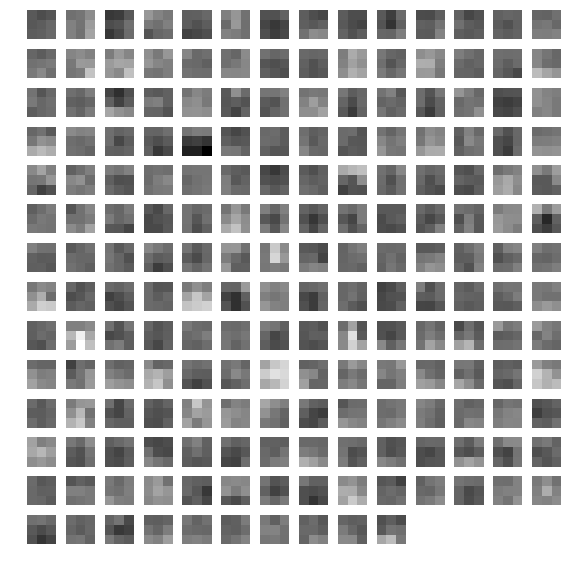

In [14]:
filters = net.params['conv5'][0].data
vis_square(filters[1])

data in the ROI Pooling layer, which is a patch in the conv1 feature map:

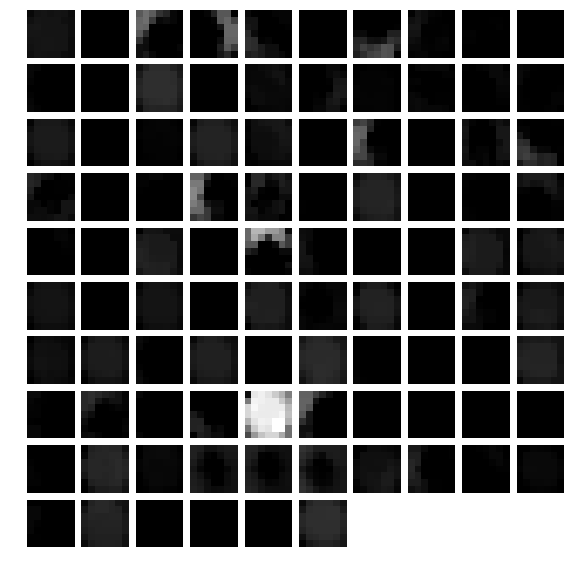

In [16]:
feat = net.blobs['roi_pool'].data[0]
vis_square(feat)

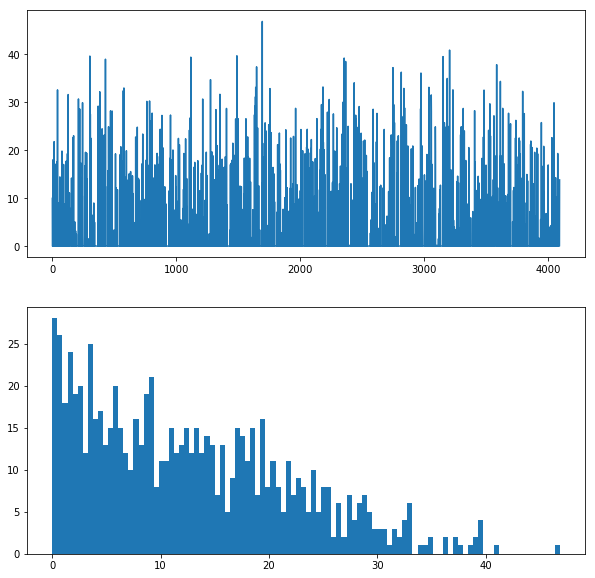

In [17]:
feat = net.blobs['regress_fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=100)

### Too slow! What should I do

In [19]:
#speed
net.forward()  # run once before timing to set up memory
%timeit net.forward()

10 loops, best of 3: 66.2 ms per loop
